# Forecasting Future Sales Using Machine Learning

Forecasting future sales of a product offers many advantages. Predicting future sales of a product helps a company manage the cost of manufacturing and marketing the product. In this notebook, I will try to you through the task of future sales prediction with machine learning using Python.

In [1]:
# EDA Libraries:

import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.regression.linear_model import OLS

import matplotlib.colors as col
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
from pathlib import Path  
import random

# Scikit-Learn models:

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import catboost as cbt
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split






# LSTM:

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
# from keras.utils import np_utils
from keras.utils import to_categorical
from keras.layers import LSTM


# ARIMA Model:

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse


import pickle
import warnings


In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)

## **Loading Dataset & Data Exploration (EDA)** 

   The first step is to load the data and transform it into a structure that we will then use for each of our models. In its raw form, each row of data represents a single day of sales at one of ten stores. Our goal is to predict monthly sales, so we will first consolidate all stores and days into total monthly sales.

In [3]:
dataset = pd.read_csv('data/sample_submission.csv')
df = dataset.copy()
df.head()

,id,sales
0,0,52
1,1,52
2,2,52
3,3,52
4,4,52


In [4]:
def load_data(file_name):
    """Returns a pandas dataframe from a csv file."""
#     return pd.read_csv(file_name)
    return pd.read_excel(file_name)


In [5]:
sales_data = load_data('data/data.xlsx')
df_s = sales_data.copy()

df_s = df_s[["CreatedOnUtc", "Quantity", "Sku"]]

In [6]:
df_s['CreatedOnUtc'] = pd.to_datetime(df_s['CreatedOnUtc'])
min_date = df_s['CreatedOnUtc'].min()
max_date = df_s['CreatedOnUtc'].max()

print("Minimum Date:", min_date)
print("Maximum Date:", max_date)

Minimum Date: 2023-03-03 00:00:00
Maximum Date: 2024-05-03 00:00:00


/var/folders/bf/t7zr8nds6f727x199sygjpbh0000gn/T/ipykernel_40634/1140341070.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_s['CreatedOnUtc'] = pd.to_datetime(df_s['CreatedOnUtc'])


In [7]:
def convert_to_sku(number):
    return f'SKU{number}'

# Applying the function to the 'store' column
df_s['Sku'] = df_s['Sku'].apply(convert_to_sku)

In [8]:
df_s.tail()

,CreatedOnUtc,Quantity,Sku
122416,2024-04-24,1,SKU0004772-S
122417,2024-04-24,1,SKU0004649-S
122418,2024-04-24,1,SKU0087063-S
122419,2024-04-03,1,SKU0028937-S
122420,2024-04-30,6,SKU0005073-S


In [9]:
df_s = df_s.rename(columns={"Sku": "store", "CreatedOnUtc": "date", "Quantity":"sales"})
df_s

,date,sales,store
0,2024-01-03,1,SKU0030693-S
1,2024-01-03,1,SKU0030715-S
2,2024-01-03,12,SKU0030784-S
3,2024-01-15,6,SKU0028917-S
4,2024-01-20,1,SKU0023160-S
...,...,...,...
122416,2024-04-24,1,SKU0004772-S
122417,2024-04-24,1,SKU0004649-S
122418,2024-04-24,1,SKU0087063-S
122419,2024-04-03,1,SKU0028937-S


In [10]:
df_s["sales"] = pd.to_numeric(df_s["sales"], errors="coerce")

In [11]:
# To view basic statistical details about dataset:

df_s['sales'].describe()

count    122421.000000
mean          1.861984
std           2.291571
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         175.000000
Name: sales, dtype: float64

 <div class="alert alert-block alert-danger" style ="background-color : #e6ebef;">
    <h4 style="padding: 15px;
              color:black;">📌 Sales seem to be unbalanced!
    </h4>
  </div>

<Axes: >

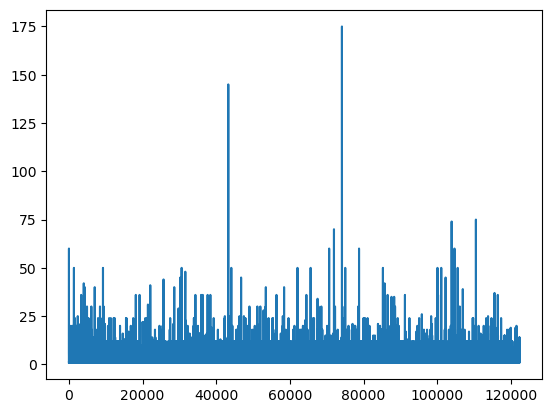

In [12]:
df_s['sales'].plot()


> Returns a dataframe where each row represents total sales for a given month. Columns include 'date' by month and 'sales'.
    

In [13]:
def monthlyORyears_sales(data,time=['monthly','years']):
    data = data.copy()
    if time == "monthly":
        # Drop the day indicator from the date column:
        data.date = data.date.apply(lambda x: str(x)[:-3])
    else:
        data.date = data.date.apply(lambda x: str(x)[:4])
        
   # Sum sales per month: 
    data = data.groupby('date')['sales'].sum().reset_index()
    data.date = pd.to_datetime(data.date)
        
    return data 

In [14]:
m_df = monthlyORyears_sales(df_s,"monthly")

m_df.to_csv('./monthly_data.csv')

In [15]:
m_df.head(10)

,date,sales
0,2023-03-03,2
1,2023-05-11,2
2,2023-05-22,4
3,2023-08-02,12
4,2023-08-03,43
5,2023-08-04,20
6,2023-08-05,51
7,2023-08-06,28
8,2023-08-07,47
9,2023-08-08,50


> In our new data frame, each row now represents the total sales for a given month across stores.

In [16]:
y_df = monthlyORyears_sales(df_s,"years")
y_df

,date,sales
0,2023-01-01,22322
1,2024-01-01,205624


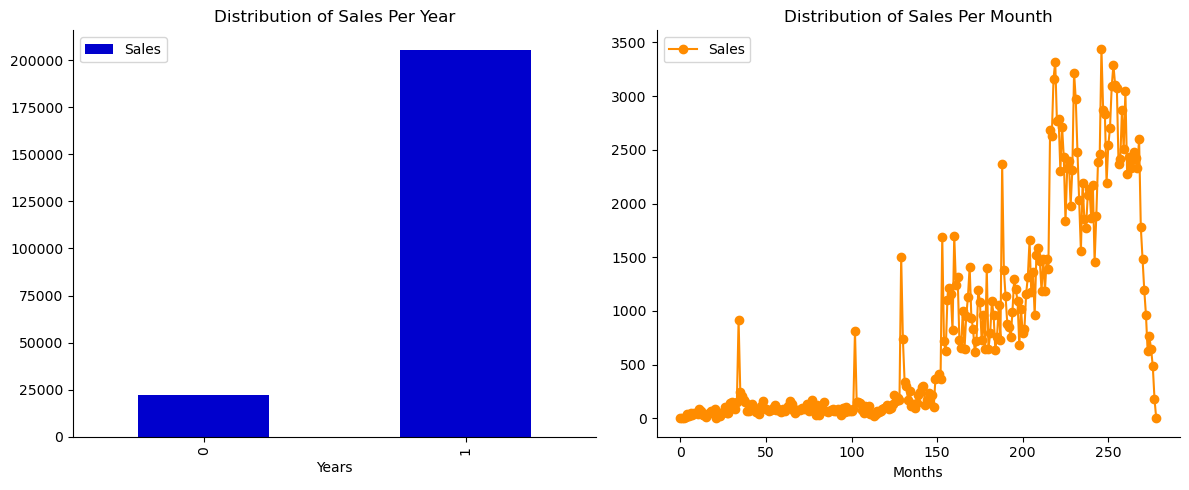

In [17]:
layout = (1, 2)

raw = plt.subplot2grid(layout, (0 ,0))
law = plt.subplot2grid(layout, (0 ,1))

years = y_df['sales'].plot(kind = "bar",color = 'mediumblue', label="Sales",ax=raw, figsize=(12,5))
months = m_df['sales'].plot(marker = 'o',color = 'darkorange', label="Sales", ax=law)

years.set(xlabel = "Years",title = "Distribution of Sales Per Year")
months.set(xlabel = "Months", title = "Distribution of Sales Per Mounth")

sns.despine()
plt.tight_layout()

years.legend()
months.legend()


<div class="alert alert-block alert-danger" style ="background-color : #e6ebef;">
    <p style="padding: 15px;
              color:black;">📌 If we plot the total monthly sales over time, we see that the average monthly sales increase over time, so our data is not stationary.
    </p>
</div>

[🦎 TREND AND SEASONALITY](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646)
> There are many other models to forecast time series, such as weighted
moving average models or autoregressive integrated moving average
(ARIMA) models. Some of them require you to first remove the trend
and seasonality. For example, if you are studying the number of active
users on your website, and it is growing by 10% every month, you
would have to remove this trend from the time series. Once the model
is trained and starts making predictions, you would have to add the
trend back to get the final predictions. Similarly, if you are trying to
predict the amount of sunscreen lotion sold every month, you will
probably observe strong seasonality: since it sells well every summer,
a similar pattern will be repeated every year. You would have to
remove this seasonality from the time series, for example by
computing the difference between the value at each time step and the
value one year earlier (this technique is called differencing). Again,
after the model is trained and makes predictions, you would have to
add the seasonal pattern back to get the final predictions.


# **Data Exploration (EDA)**

 To make it stationary, we will calculate the difference between the sales of each month and add it to our data frame as a new column.
> Further details of the stationary and differences are available [here.](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/) But first let's take a closer look at the data set you work with by learning more about the data.

In [18]:
def sales_time(data):
    """Time interval of dataset:"""

    data.date = pd.to_datetime(data.date)
    n_of_days = data.date.max() - data.date.min()
    n_of_years = int(n_of_days.days / 365)
    
    print(f"Days: {n_of_days.days}\nYears: {n_of_years}\nMonth: {12 * n_of_years}")


In [19]:
sales_time(df_s)

Days: 427
Years: 1
Month: 12


**Sales Data Per Store**

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

def sales_per_store(data):
    sales_by_store = data.groupby('store')['sales'].sum().reset_index()
    
    fig, ax = plt.subplots(figsize=(8,3))
    sns.barplot(x=sales_by_store['store'], y=sales_by_store['sales'], color='darkred')
    
    ax.set(xlabel="Store Id", ylabel="Sum of Sales", title="Total Sales Per Store")
    
    return sales_by_store

,store,sales
0,SKU0003705-S,28
1,SKU0003708-S,85
2,SKU0003710-S,179
3,SKU0003711-S,53
4,SKU0003714-S,65
...,...,...
1989,SKUC057852-A,1
1990,SKUC059053-A,140
1991,SKUC059195-A,153
1992,SKUC358991-A,26


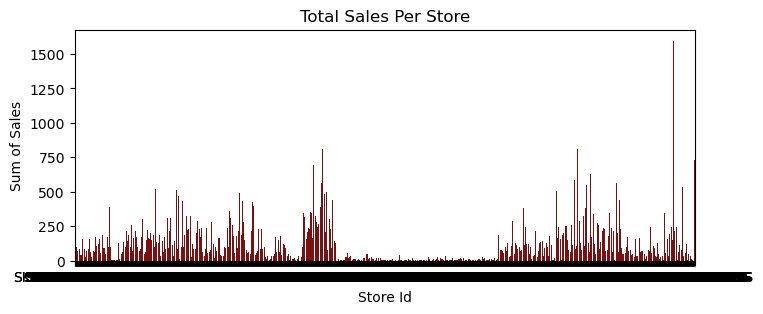

In [21]:
sales_per_store(df_s)

**Mean Monthly Sales**

In [22]:
# Overall for 5 years:

average_m_sales = m_df.sales.mean()
print(f"Overall Avarage Monthly Sales: ${average_m_sales}")

def avarage_12months():
# Last 1 years (this will be the forecasted sales):
    average_m_sales_1y = m_df.sales[-12:].mean()
    print(f"Last 12 months average monthly sales: ${average_m_sales_1y}")
avarage_12months()

Overall Avarage Monthly Sales: $817.010752688172
Last 12 months average monthly sales: $1088.75


# **Determining Time Series Stationary**

The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented in this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.

In [23]:
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x=x_col, y=y_col, data=data, ax=ax, color='darkblue', label='Total Sales')
    
    # Calculating the yearly mean of sales
    s_mean = data.groupby(data[x_col].dt.year)[y_col].mean().reset_index()
    s_mean[x_col] = pd.to_datetime(s_mean[x_col], format='%Y')  # Adjust this if the format doesn't match

    # Plotting the yearly mean
    sns.lineplot(x=s_mean[x_col], y=s_mean[y_col], ax=ax, color='darkred', label='Yearly Average Sales')

    ax.set(title=title, xlabel=x_col, ylabel=y_col)
    ax.legend()
    plt.show()


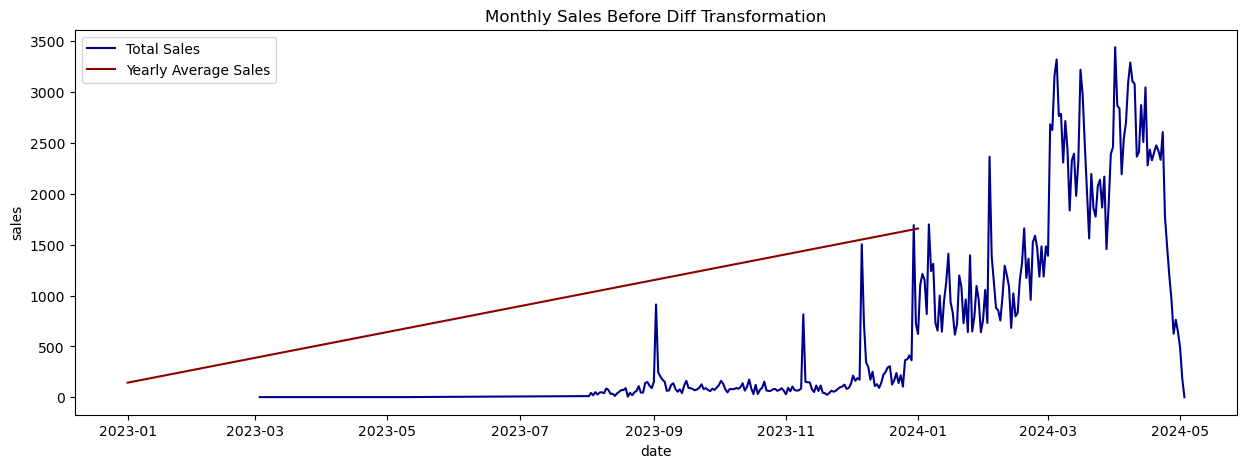

In [24]:
time_plot(m_df, 'date', 'sales', 'Monthly Sales Before Diff Transformation' )

* **Differencing**

In this method, we compute the difference of consecutive terms in the series. Differencing is typically performed to get rid of the varying mean. 

In [25]:
def get_diff(data):
    """Calculate the difference in sales month over month:"""
    
    data['sales_diff'] = data.sales.diff()
    data = data.dropna()
    
    data.to_csv('./stationary_df.csv')
    
    return data


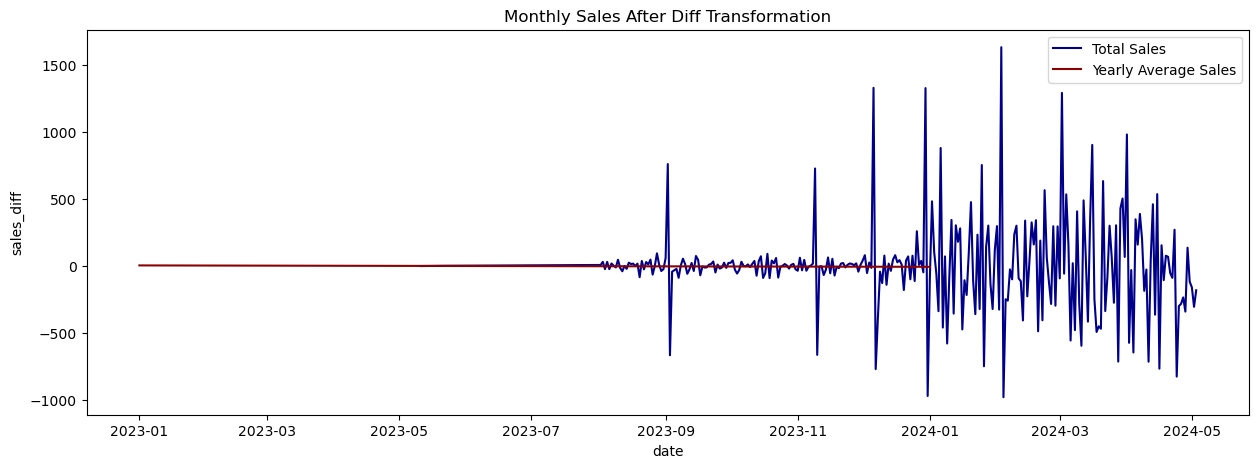

In [26]:
stationary_df = get_diff(m_df)
time_plot(stationary_df, 'date', 'sales_diff', 
          'Monthly Sales After Diff Transformation')

<div class="alert alert-block alert-danger" style ="background-color : #e6ebef;">
    <h5 style="padding: 15px;
              color:black;">📌 Now that our data represent monthly sales and we have transformed it to be stationary, we will set up the 
                            data for our different model types. <br> <br>
              ✔ To do this, we will 
                            define two different structures: 
        <br> <br>
                    1. one will be used for ARIMA modeling,
        <br><br>
                    2. the other will be used for the rest of the models.
    </h5>
</div>



# **Preparing Dataset Modeling**

# ARIMA Modeling

>  For our Arima model, we will need only a datetime index and the dependent variable (diff in sales) columns.

In [27]:
def build_arima_data(data):
    """Generates a csv-file with a datetime index and a dependent sales column for ARIMA modeling."""
    
    da_data = data.set_index('date').drop('sales', axis=1)
    da_data.dropna(axis=0)
    
    da_data.to_csv('./arima_df.csv')
    
    return da_data


In [28]:
datatime_df = build_arima_data(stationary_df)
datatime_df # ARIMA Dataframe

,sales_diff
date,
2023-05-11,0.0
2023-05-22,2.0
2023-08-02,8.0
2023-08-03,31.0
2023-08-04,-23.0
...,...
2024-04-29,137.0
2024-04-30,-117.0
2024-05-01,-159.0


* **Observing Lags**

For our other models, we will create a new data frame where each feature represents a previous month’s sales. To determine how many months to include in our feature set, we will observe the autocorrelation and partial autocorrelation plots and use the [rules for selecting lags in ARIMA modeling](https://people.duke.edu/~rnau/arimrule.htm). This way, we can keep consistent a look-back period for our ARIMA and regressive models.

>  **[Statsmodels](https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html)**



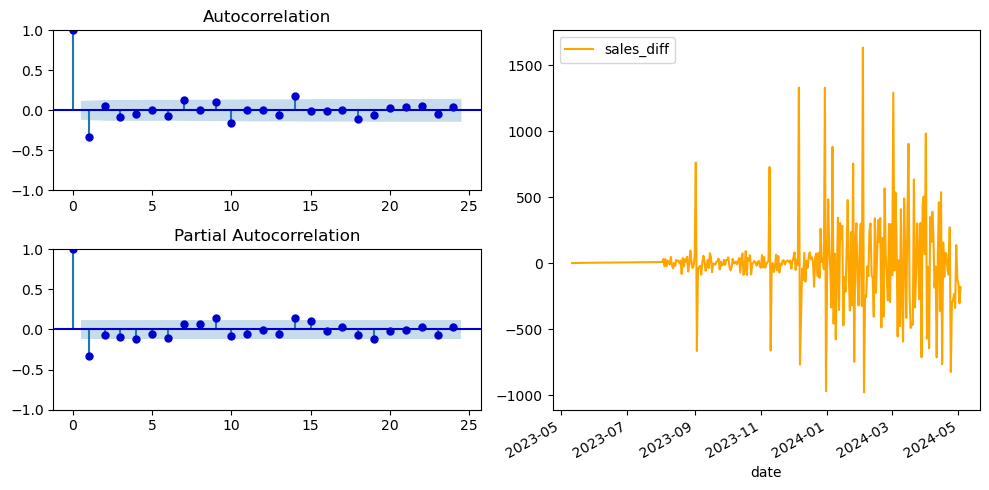

In [29]:
def plots_lag(data, lags=None):
    """Convert dataframe to datetime index"""
    dt_data = data.set_index('date').drop('sales', axis=1)
    dt_data.dropna(axis=0)
    
    
    law  = plt.subplot(122)
    acf  = plt.subplot(221)
    pacf = plt.subplot(223)
    
    dt_data.plot(ax=law, figsize=(10, 5), color='orange')
    # Plot the autocorrelation function:
    smt.graphics.plot_acf(dt_data, lags=lags, ax=acf, color='mediumblue')
    smt.graphics.plot_pacf(dt_data, lags=lags, ax=pacf, color='mediumblue')
    
    # Will also adjust spacing between subplots to minimize the overlaps:
    plt.tight_layout()

plots_lag(stationary_df, lags=24);
    
    


> [🎦 Autocorrelation Function](https://www.youtube.com/watch?v=ZjaBn93YPWo&t=12s)


>[ Time Series & Autocorrelation](https://online.stat.psu.edu/stat501/book/export/html/995 )


<div class="alert alert-block alert-danger" style ="background-color : #e6ebef;">
    <p style="padding: 15px;
              color:black;">📌 Based on the above, we will choose our look-back period to be 12 months. We will, therefore, generate a data frame that has 13 columns, 1 column for each of the 12 months and the column for our dependent variable, difference in sales.
    </p>
</div>


# Regressive Modeling

> Let's create a CSV file where each row represents a month and the columns will have sales, dependent variables, and previous sales for each delay. The 12 delay properties are created according to the EDA. Data is used for regression modeling.


Code was taken from [Baris Karaman’s 'Data Driven Growth' series.](https://towardsdatascience.com/predicting-sales-611cb5a252de)

In [30]:
# Let's create a data frame for transformation from time series to supervised:

def built_supervised(data):
    supervised_df = data.copy()

    # Create column for each lag:
    for i in range(1, 13):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['sales_diff'].shift(i)

    # Drop null values:
    supervised_df = supervised_df.dropna().reset_index(drop=True)

    supervised_df.to_csv('./model_df.csv', index=False)
    
    return supervised_df
    

In [31]:
model_df = built_supervised(stationary_df)
model_df 

,date,sales,sales_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2023-08-12,34,-39.0,-14.0,47.0,-10.0,3.0,19.0,-23.0,31.0,-23.0,31.0,8.0,2.0,0.0
1,2023-08-13,35,1.0,-39.0,-14.0,47.0,-10.0,3.0,19.0,-23.0,31.0,-23.0,31.0,8.0,2.0
2,2023-08-14,14,-21.0,1.0,-39.0,-14.0,47.0,-10.0,3.0,19.0,-23.0,31.0,-23.0,31.0,8.0
3,2023-08-15,39,25.0,-21.0,1.0,-39.0,-14.0,47.0,-10.0,3.0,19.0,-23.0,31.0,-23.0,31.0
4,2023-08-16,54,15.0,25.0,-21.0,1.0,-39.0,-14.0,47.0,-10.0,3.0,19.0,-23.0,31.0,-23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,2024-04-29,762,137.0,-340.0,-234.0,-282.0,-299.0,-825.0,271.0,-88.0,-53.0,69.0,77.0,-105.0,155.0
262,2024-04-30,645,-117.0,137.0,-340.0,-234.0,-282.0,-299.0,-825.0,271.0,-88.0,-53.0,69.0,77.0,-105.0
263,2024-05-01,486,-159.0,-117.0,137.0,-340.0,-234.0,-282.0,-299.0,-825.0,271.0,-88.0,-53.0,69.0,77.0
264,2024-05-02,182,-304.0,-159.0,-117.0,137.0,-340.0,-234.0,-282.0,-299.0,-825.0,271.0,-88.0,-53.0,69.0


In [32]:
model_df.info() # Supervised Dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        266 non-null    datetime64[ns]
 1   sales       266 non-null    int64         
 2   sales_diff  266 non-null    float64       
 3   lag_1       266 non-null    float64       
 4   lag_2       266 non-null    float64       
 5   lag_3       266 non-null    float64       
 6   lag_4       266 non-null    float64       
 7   lag_5       266 non-null    float64       
 8   lag_6       266 non-null    float64       
 9   lag_7       266 non-null    float64       
 10  lag_8       266 non-null    float64       
 11  lag_9       266 non-null    float64       
 12  lag_10      266 non-null    float64       
 13  lag_11      266 non-null    float64       
 14  lag_12      266 non-null    float64       
dtypes: datetime64[ns](1), float64(13), int64(1)
memory usage: 31.3 KB


<div class="alert alert-block alert-danger" style ="background-color : #e6ebef;">
    <h5 style="padding: 15px;
              color:black;">📌 Now we have two separate data structures: <br> <br><br>
              ✔ Our Arima structure which includes a DataTime index,
        <br><br>
             ✔ Our supervised structure which includes lags as features.
    </h5>
</div>


## **Functions For Modeling** 

To create and assess all of our models, we will use a series of helper functions that perform the following functions:
* *Train test split*
* *Scale the data*
* *Reverse scaling*
* *Create a predictions data frame*
* *Score the models*


 # Train Test Split

>       We detach our data so that the last 12 months are part of the test set and the rest of the data is used to train our model.

In [33]:
def train_test_split(data):
    data = data.drop(['sales','date'], axis=1)
    train , test = data[:-12].values, data[-12:].values
    
    return train, test

train, test = train_test_split(model_df)
print(f"Shape of  Train: {train.shape}\nShape of  Test: {test.shape}")

Shape of  Train: (254, 13)
Shape of  Test: (12, 13)


 # Scale The Data

>      Using a min-max scaler, we will scale the data so that all of our variables fall within the range of -1 to 1.

In [34]:
def scale_data(train_set,test_set):
    """Scales data using MinMaxScaler and separates data into X_train, y_train,
    X_test, and y_test."""
    
    # Apply Min Max Scaler:
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # Reshape training set:
    train_set = train_set.reshape(train_set.shape[0],
                                  train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # Reshape test set:
    test_set = test_set.reshape(test_set.shape[0], 
                                test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel() # returns the array, flattened!
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler


X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)
print(f"Shape of X Train: {X_train.shape}\nShape of y Train: {y_train.shape}\nShape of X Test: {X_test.shape}\nShape of y Test: {y_test.shape}")

Shape of X Train: (254, 12)
Shape of y Train: (254,)
Shape of X Test: (12, 12)
Shape of y Test: (12,)


 # Reverse Scaling
>       After running our models, we will use this helper function to reverse the scaling of step 2.

In [35]:
def re_scaling(y_pred, x_test, scaler_obj, lstm=False):
    """For visualizing and comparing results, undoes the scaling effect on predictions."""
   # y_pred: model predictions
   # x_test: features from the test set used for predictions
   # scaler_obj: the scaler objects used for min-max scaling
   # lstm: indicate if the model run is the lstm. If True, additional transformation occurs 
    
    # Reshape y_pred:
    y_pred = y_pred.reshape(y_pred.shape[0],
                            1,
                            1)

    if not lstm:
        x_test = x_test.reshape(x_test.shape[0],
                                1, 
                                x_test.shape[1])

    # Rebuild test set for inverse transform:
    pred_test_set = []
    for index in range(0, len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index], 
                                             x_test[index]],
                                             axis=1) )

    # Reshape pred_test_set:
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0],
                                          pred_test_set.shape[2])

    # Inverse transform:
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)

    return pred_test_set_inverted
    


 # Predictions Dataframe
>     Generate a dataframe that includes the actual sales captured in our test set and the predicted results from our model so that we can quantify our success.

In [36]:
def prediction_df(unscale_predictions, origin_df):
    """Generates a dataframe that shows the predicted sales for each month
    for plotting results."""
    
    # unscale_predictions: the model predictions that do not have min-max or other scaling applied
    # origin_df: the original monthly sales dataframe
    
    # Create dataframe that shows the predicted sales:
    result_list = []
    sales_dates = list(origin_df[-13:].date)
    act_sales = list(origin_df[-13:].sales)

    for index in range(0, len(unscale_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscale_predictions[index][0] + act_sales[index])
        result_dict['date'] = sales_dates[index + 1]
        result_list.append(result_dict)

    df_result = pd.DataFrame(result_list)

    return df_result

# Score The Models
>      This helper function will save the root mean squared error (RMSE) and mean absolute error (MAE) of our predictions to compare the performance of our models.
[Regression Metrics](https://scikit-learn.org/0.24/modules/model_evaluation.html#regression-metrics)

![](https://4.bp.blogspot.com/-wG7IbjTfE6k/XGUvqm7TCVI/AAAAAAAAAZU/vpH1kuKTIooKTcVlnm1EVRCXLVZM9cPNgCLcBGAs/s1600/formula-MAE-MSE-RMSE-RSquared.JPG)

In [37]:
model_scores = {}

def get_scores(unscale_df, origin_df, model_name):
    """Prints the root mean squared error, mean absolute error, and r2 scores
    for each model. Saves all results in a model_scores dictionary for
    comparison."""

    
    rmse = np.sqrt(mean_squared_error(origin_df.sales[-12:], 
                                      unscale_df.pred_value[-12:]))
    
    mae = mean_absolute_error(origin_df.sales[-12:], 
                              unscale_df.pred_value[-12:])
    
    r2 = r2_score(origin_df.sales[-12:], 
                  unscale_df.pred_value[-12:])
    
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}\nMAE: {mae}\nR2 Score: {r2}")


# Graph of Results

In [38]:
def plot_results(results, origin_df, model_name):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x='date', y='sales', data=origin_df, ax=ax, label='Original', color='blue')
    sns.lineplot(x='date', y='pred_value', data=results, ax=ax, label='Predicted', color='red')
    
    ax.set(xlabel="Date", ylabel="Sales", title=f"{model_name} Sales Forecasting Prediction")
    ax.legend()
    plt.show()
    
    ax.legend(loc='best')
    
    filepath = Path('./model_output/{model_name}_forecasting.svg')  
    filepath.parent.mkdir(parents=True, exist_ok=True) 
    plt.savefig(f'./model_output/{model_name}_forecasting.svg')

In [39]:
def regressive_model(train_data, test_data, model, model_name):
    """Runs regressive models in SKlearn framework. First calls scale_data
    to split into X and y and scale the data. Then fits and predicts. Finally,
    predictions are unscaled, scores are printed, and results are plotted and
    saved."""
    
    # Split into X & y and scale data:
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data,
                                                                 test_data)

    # Run sklearn models:
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test) # y_pred=predictions

    # Undo scaling to compare predictions against original data:
    origin_df = m_df
    unscaled = re_scaling(predictions, X_test, scaler_object) # unscaled_predictions
    unscaled_df = prediction_df(unscaled, origin_df)

    # Print scores and plot results:
    get_scores(unscaled_df, origin_df, model_name)
    plot_results(unscaled_df, origin_df, model_name)

# **Modeling**
# Regressive Models
* Linear Regression
* Random Forest Regressor
* XGBoost
* LSTM

# Linear Regression

RMSE: 566.2990964734685
MAE: 541.6666666666666
R2 Score: 0.47969192690756013


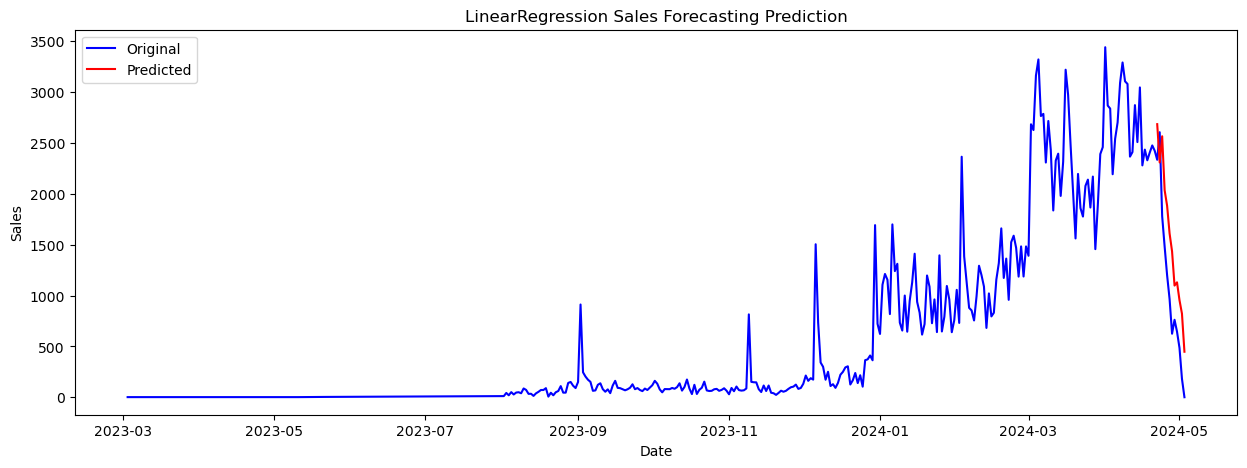

<Figure size 640x480 with 0 Axes>

In [40]:
regressive_model(train, test, LinearRegression(), 'LinearRegression')

# Ridge Regression

RMSE: 510.38041367852924
MAE: 482.5
R2 Score: 0.5773734017142506


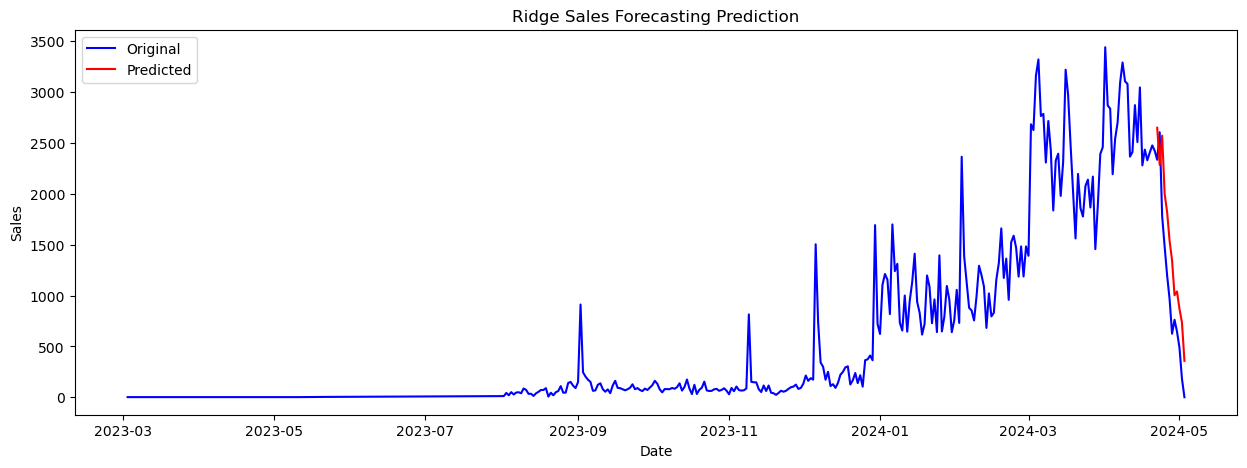

<Figure size 640x480 with 0 Axes>

In [41]:
regressive_model(train, test, Ridge(alpha=1.0), 'Ridge')

#  Lasso Regression

RMSE: 332.7357560186962
MAE: 275.75
R2 Score: 0.8203745897802394


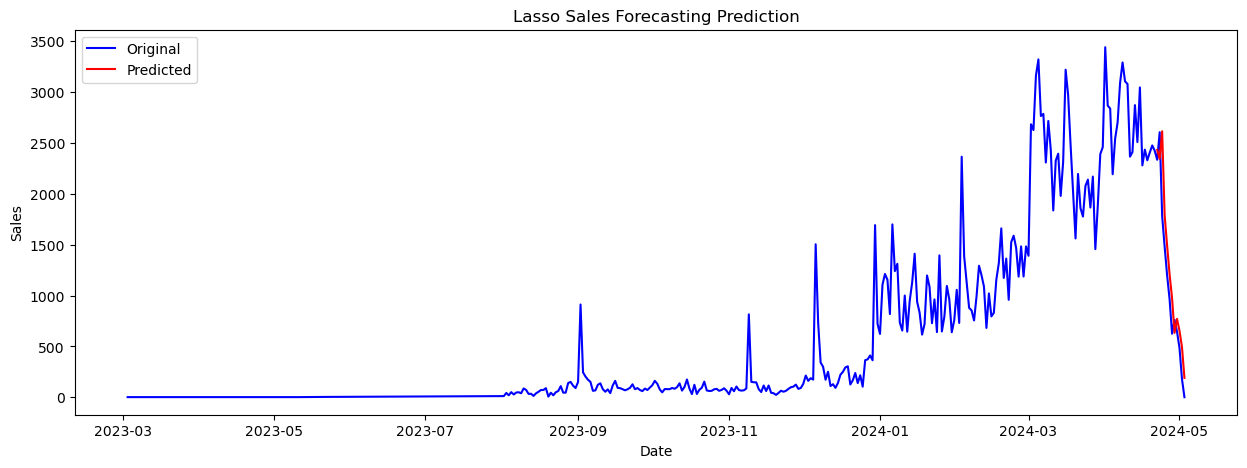

<Figure size 640x480 with 0 Axes>

In [42]:
regressive_model(train, test, Lasso(alpha=0.1), 'Lasso')

# Elastic Net

RMSE: 332.7357560186962
MAE: 275.75
R2 Score: 0.8203745897802394


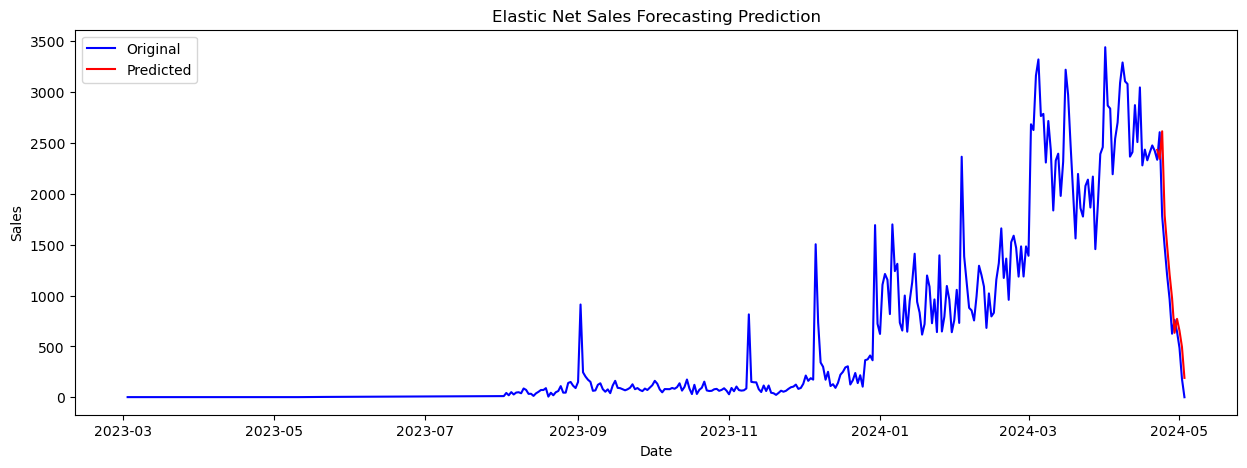

<Figure size 640x480 with 0 Axes>

In [43]:
regressive_model(train, test, ElasticNet(alpha=0.1, l1_ratio=0.7), 'Elastic Net')

# Support Vector Machine

RMSE: 680.9123169199786
MAE: 635.75
R2 Score: 0.2477690342121024


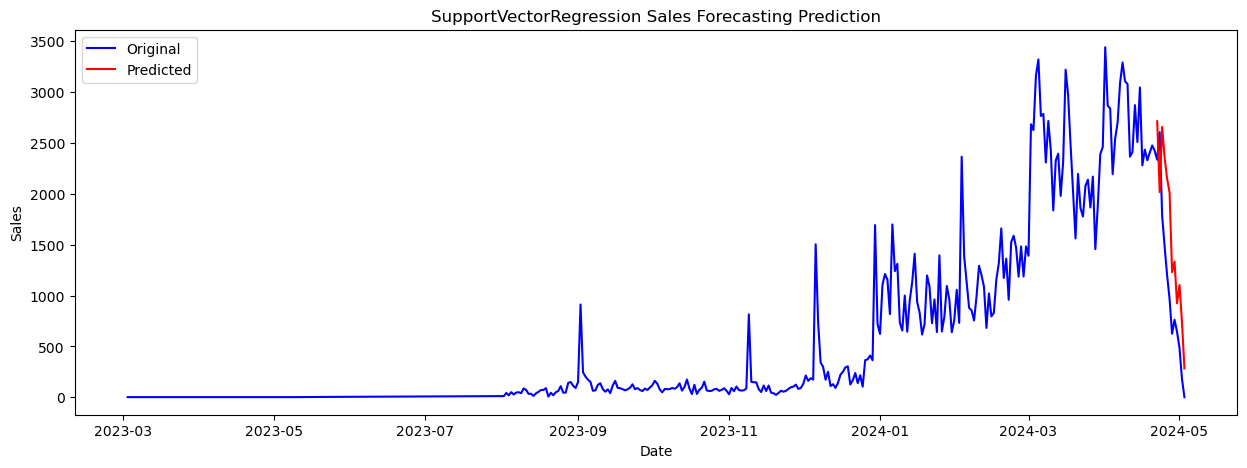

<Figure size 640x480 with 0 Axes>

In [44]:
regressive_model(train, test, SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1), 'SupportVectorRegression')

# Decision Tree

RMSE: 402.2659775157062
MAE: 314.75
R2 Score: 0.7374600292302969


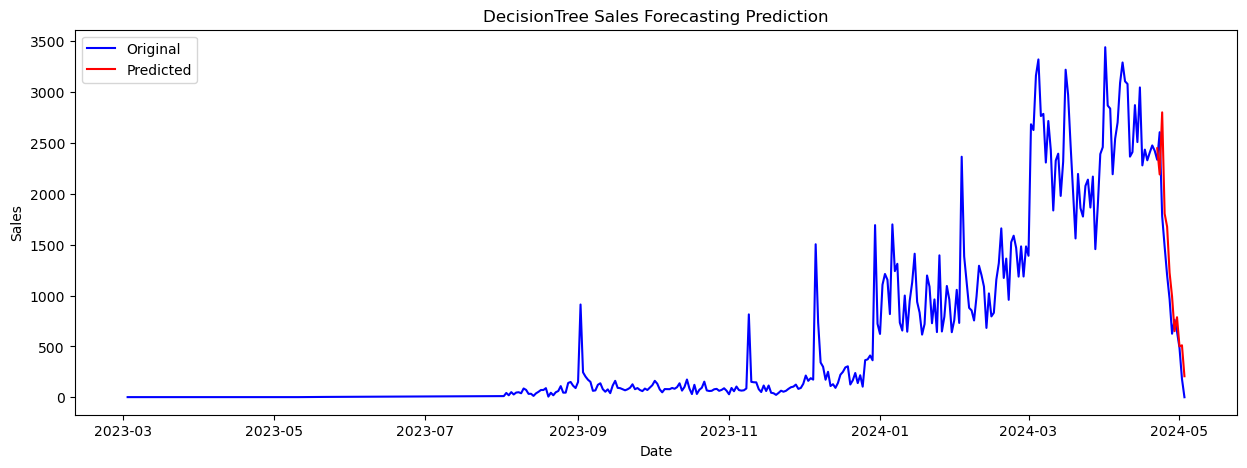

<Figure size 640x480 with 0 Axes>

In [45]:
regressive_model(train, test, DecisionTreeRegressor(max_depth=3), 'DecisionTree')



 # Random Forest Regressor

RMSE: 509.1151637890979
MAE: 429.4166666666667
R2 Score: 0.5794662149881948


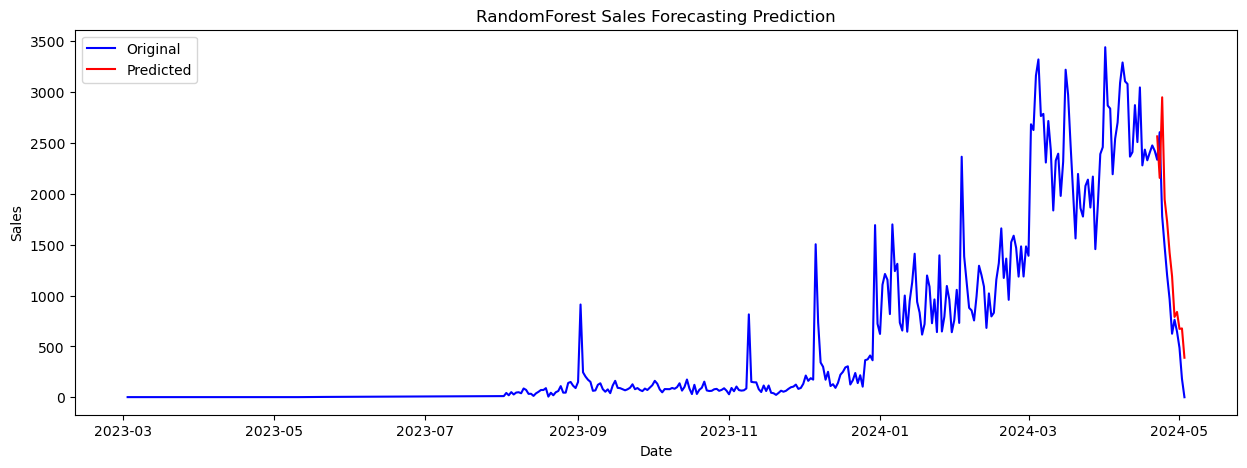

<Figure size 640x480 with 0 Axes>

In [46]:
regressive_model(train, test, RandomForestRegressor(n_estimators=100, max_depth=20), 
          'RandomForest')

#  Gradient Boosting Regressor

RMSE: 474.1259502143567
MAE: 420.0833333333333
R2 Score: 0.6352827712990379


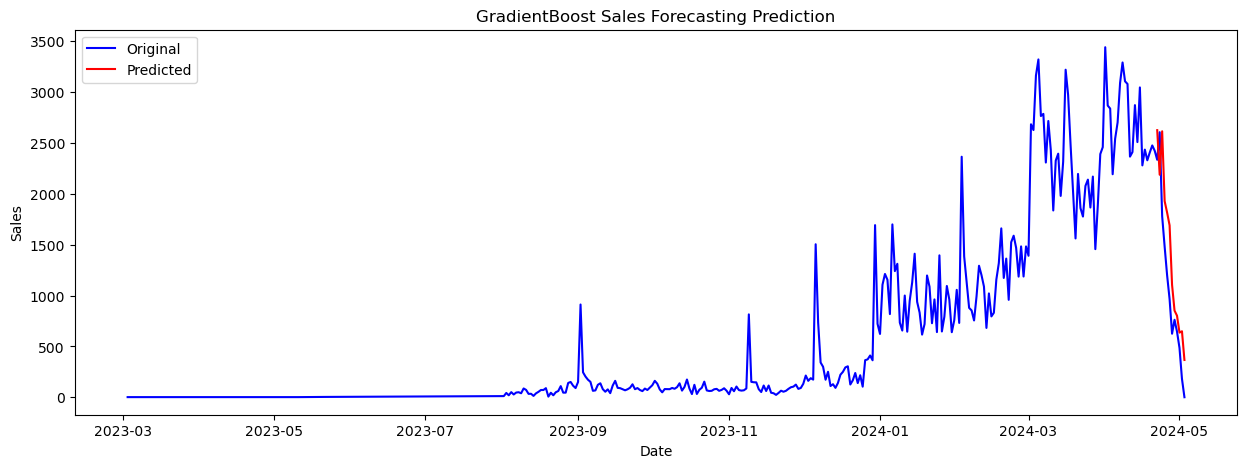

<Figure size 640x480 with 0 Axes>

In [47]:
regressive_model(train, test, GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3), 'GradientBoost')

# CatBoost

RMSE: 542.6226435869897
MAE: 475.5
R2 Score: 0.5222896477772545


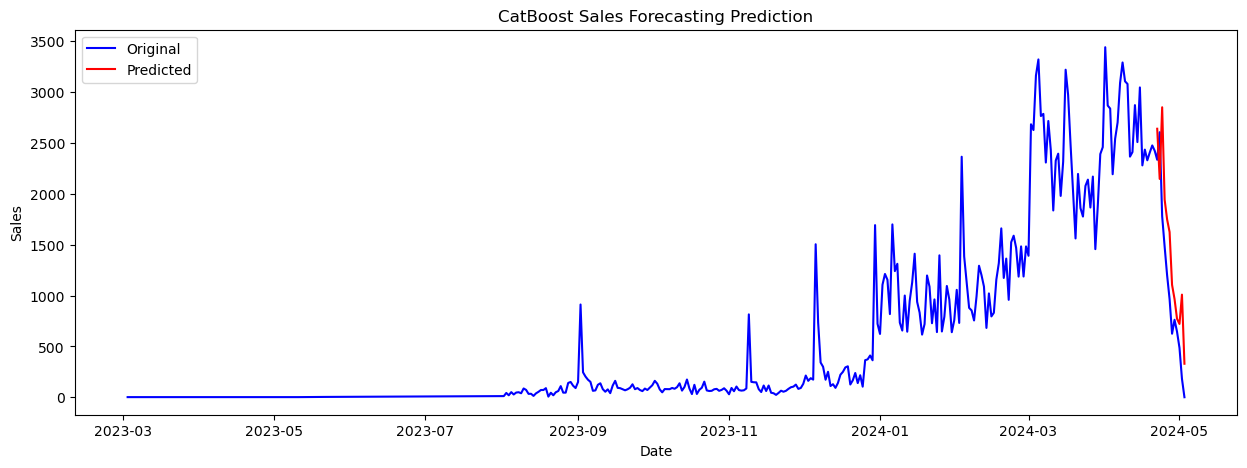

<Figure size 640x480 with 0 Axes>

In [48]:
regressive_model(train, test, cbt.CatBoostRegressor(iterations=100, learning_rate=0.2, depth=3, silent=True), 'CatBoost')


# XGBoost

RMSE: 598.6022608265581
MAE: 523.0
R2 Score: 0.418639484115241


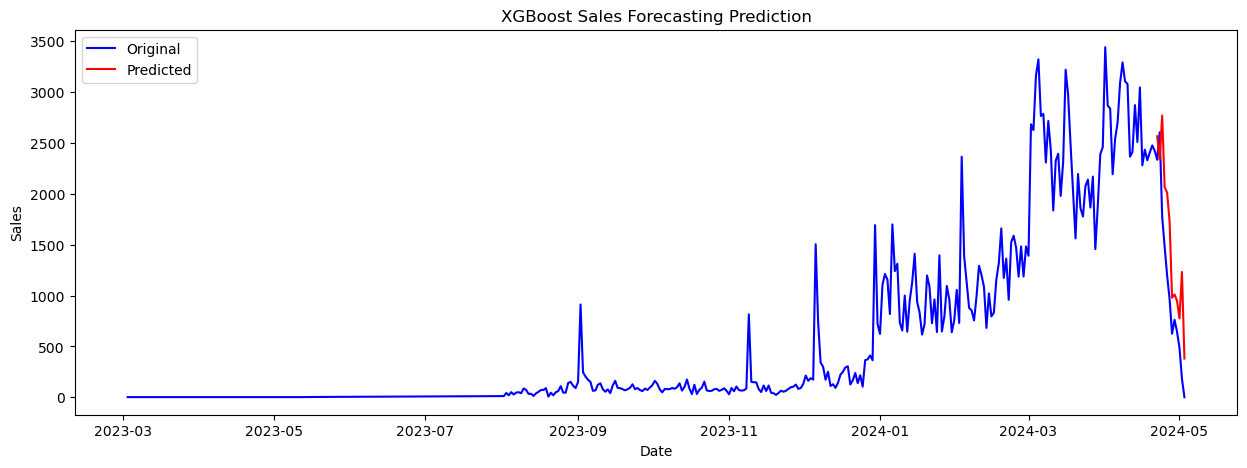

<Figure size 640x480 with 0 Axes>

In [49]:
regressive_model(train, test, XGBRegressor(n_estimators=100,max_depth=3, 
                                           learning_rate=0.2,objective='reg:squarederror'), 'XGBoost')

# [LSTM](https://keras.io/api/layers/recurrent_layers/lstm/)

> LSTM is a type of recurring neural network that is especially useful for predicting sequential data. [Getting started with the Keras Sequential model](https://faroit.com/keras-docs/1.2.0/getting-started/sequential-model-guide/#sequence-classification-with-lstm)

In [50]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

def lstm_model(train_data, test_data):
    """Runs a long-short-term-memory neural net with 2 dense layers. 
    Generates predictions that are then unscaled. 
    Scores are printed and the results are plotted and saved."""
    # Assuming scale_data, re_scaling, prediction_df, get_scores, plot_results are defined elsewhere

    # Split into X & y and scale data:
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
   
    # Build LSTM:
    model = Sequential()
    model.add(LSTM(4, input_shape=(X_train.shape[1], X_train.shape[2]), stateful=False))  # Stateful is set to False for simplicity
    model.add(Dense(1))  # Output layer

    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Fit the model
    model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=2, shuffle=False)

    # Predictions
    predictions = model.predict(X_test, batch_size=1)

    # Set the origin_df for comparison (ensure this is set appropriately)
    origin_df = m_df  # or whatever data frame you are comparing to

    # Undo scaling to compare predictions against original data:
    unscaled = re_scaling(predictions, X_test, scaler_object, lstm=True)
    unscaled_df = prediction_df(unscaled, origin_df)

    # Get scores and plot results
    get_scores(unscaled_df, origin_df, 'LSTM')
    plot_results(unscaled_df, origin_df, 'LSTM')

    return unscaled_df


Epoch 1/50


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


254/254 - 0s - 2ms/step - loss: 0.0753
Epoch 2/50
254/254 - 0s - 261us/step - loss: 0.0692
Epoch 3/50
254/254 - 0s - 263us/step - loss: 0.0659
Epoch 4/50
254/254 - 0s - 263us/step - loss: 0.0634
Epoch 5/50
254/254 - 0s - 264us/step - loss: 0.0613
Epoch 6/50
254/254 - 0s - 263us/step - loss: 0.0596
Epoch 7/50
254/254 - 0s - 263us/step - loss: 0.0581
Epoch 8/50
254/254 - 0s - 265us/step - loss: 0.0567
Epoch 9/50
254/254 - 0s - 263us/step - loss: 0.0555
Epoch 10/50
254/254 - 0s - 261us/step - loss: 0.0544
Epoch 11/50
254/254 - 0s - 260us/step - loss: 0.0534
Epoch 12/50
254/254 - 0s - 259us/step - loss: 0.0525
Epoch 13/50
254/254 - 0s - 260us/step - loss: 0.0518
Epoch 14/50
254/254 - 0s - 261us/step - loss: 0.0511
Epoch 15/50
254/254 - 0s - 262us/step - loss: 0.0505
Epoch 16/50
254/254 - 0s - 261us/step - loss: 0.0499
Epoch 17/50
254/254 - 0s - 258us/step - loss: 0.0494
Epoch 18/50
254/254 - 0s - 261us/step - loss: 0.0490
Epoch 19/50
254/254 - 0s - 260us/step - loss: 0.0486
Epoch 20/50
254

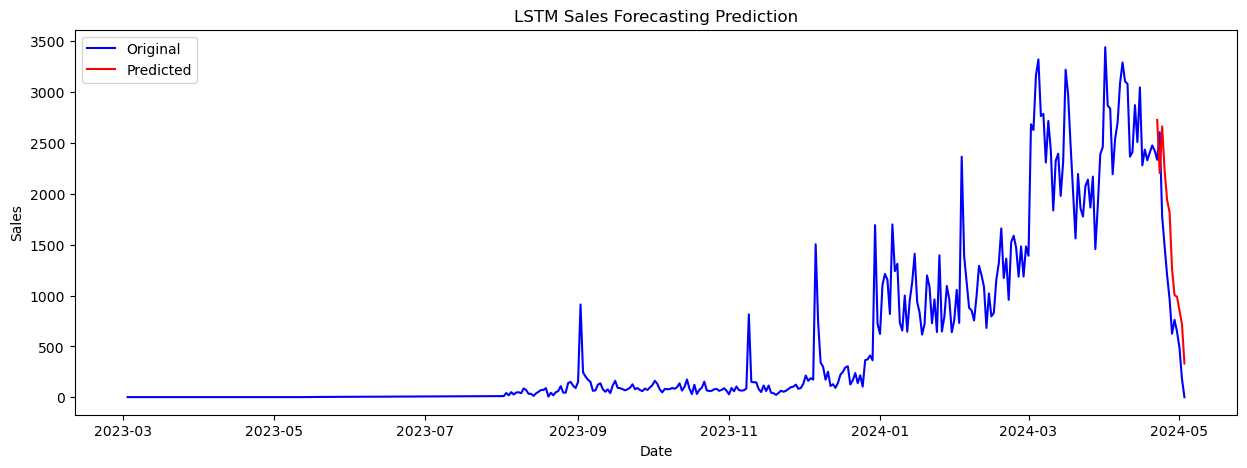

,pred_value,date
0,2725,2024-04-22
1,2204,2024-04-23
2,2662,2024-04-24
3,2226,2024-04-25
4,1940,2024-04-26
5,1816,2024-04-27
6,1260,2024-04-28
7,1004,2024-04-29
8,988,2024-04-30
9,852,2024-05-01


<Figure size 640x480 with 0 Axes>

In [51]:
lstm_model(train,test)

In [52]:
pickle.dump(model_scores, open( "model_scores.p", "wb" ))

# ARIMA Modeling

[ **SARIMAX Modeling**  ](https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/)

> We use the statsmodels SARIMAX package to train the model and generate dynamic predictions. The SARIMA model breaks down into a few parts.

     AR: represented as p, is the autoregressive model
     I : represented as d, is the differencing term
     MA: represented as q, is the moving average model
     S: enables us to add a seasonal component


In [53]:
datatime_df.index = pd.to_datetime(datatime_df.index)
datatime_df_t = datatime_df.copy()
print(datatime_df.head())

            sales_diff
date                  
2023-05-11         0.0
2023-05-22         2.0
2023-08-02         8.0
2023-08-03        31.0
2023-08-04       -23.0


<div class="alert alert-block alert-danger" style ="background-color : #e6ebef;">
    <p style="padding: 15px;
              color:black;">📌 In the code below, we define our model and then make dynamic predictions for the last 12 months of the data. For standard, non-dynamic predictions, the following month’s prediction is made using the actual sales from the prior months. In contrast, for dynamic predictions, the following month’s prediction is made using the predicted sales from the prior months.
    </p>
</div>


In [54]:
def sarimax_model(data):
    # Model:
    sar = sm.tsa.statespace.SARIMAX(data.sales_diff, order=(12, 0, 0),
                                    seasonal_order=(0, 1, 0, 12),
                                    trend='c').fit()
    
    # Generate predictions:
    start, end, dynamic = 40, 100, 7
    data['pred_value'] = sar.predict(start=start, end=end, dynamic=dynamic)
    pred_df = data.pred_value[start+dynamic:end]
    
    data[["sales_diff","pred_value"]].plot(color=['blue', 'Red'])
    plt.legend(loc='upper left')
    
    model_score = {}
    
    rmse = np.sqrt(mean_squared_error(data.sales_diff[-12:], data.pred_value[-12:]))
    mae = mean_absolute_error(data.sales_diff[-12:], data.pred_value[-12:])
    r2 = r2_score(data.sales_diff[-12:], data.pred_value[-12:])
    model_scores['ARIMA'] = [rmse, mae, r2]
    
    print(f"RMSE: {rmse}\nMAE: {mae}\nR2 Score: {r2}")
    
    return sar, data, pred_df


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.99677D+00    |proj g|=  1.38756D-02


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  6.99651D+00    |proj g|=  2.63866D-03

At iterate   10    f=  6.99651D+00    |proj g|=  3.20464D-04

At iterate   15    f=  6.99651D+00    |proj g|=  1.16862D-04

At iterate   20    f=  6.99651D+00    |proj g|=  7.06833D-04

At iterate   25    f=  6.99647D+00    |proj g|=  3.51273D-03

At iterate   30    f=  6.99609D+00    |proj g|=  3.09182D-03

At iterate   35    f=  6.99607D+00    |proj g|=  4.46491D-04

At iterate   40    f=  6.99607D+00    |proj g|=  6.85655D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     40     44      1     0     0   6.857D-05   6.996D+00
  F =   6.99606864889

ValueError: Input contains NaN.

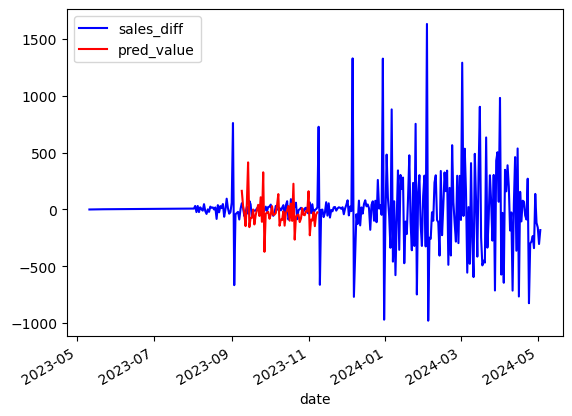

In [55]:
sar, datatime_df, predictions = sarimax_model(datatime_df)

[statsmodels](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMAResults.plot_diagnostics.html)

In [ ]:
sar.plot_diagnostics(figsize=(12, 8));

In [ ]:
pickle.dump(model_scores, open( "ARIMAmodel_scores.p", "wb" ))

# Traditional Models

In [ ]:
datatime_df_t.shape

In [ ]:
# Example for Holt's Linear Trend Model
from statsmodels.tsa.holtwinters import Holt

train_size = int(len(datatime_df_t) * 0.8)
train_data, test_data = datatime_df_t['sales_diff'].iloc[:train_size], datatime_df_t['sales_diff'].iloc[train_size:]

model = Holt(train_data)
model_fit = model.fit(optimized=True)
forecasts = model_fit.forecast(len(test_data))

plt.figure(figsize=(12, 6))
plt.plot(datatime_df_t['sales_diff'], label='Actual Sales', color='blue')
plt.plot(train_data.index, model_fit.fittedvalues, label='Fitted by Holt', color='green')
plt.plot(test_data.index, forecasts, label='Forecast by Holt', color='red')
plt.title('Holt’s Linear Trend Model Forecast')
plt.legend()
plt.show()


## **Comparing Models**

In [ ]:
def create_results_df():
    results_dict = pickle.load(open("model_scores.p", "rb"))
    
    results_dict.update(pickle.load(open("ARIMAmodel_scores.p", "rb")))
    
    results_df = pd.DataFrame.from_dict(results_dict, orient='index', 
                                        columns=['RMSE', 'MAE','R2'])
    
    results_df = results_df.sort_values(by='RMSE', ascending=False).reset_index()
    
    results_df.to_csv('./results.csv')
    
    fig, ax = plt.subplots(figsize=(12, 5))
    sns.lineplot(np.arange(len(results_df)), 'RMSE', data=results_df, ax=ax, 
                 label='RMSE', color='darkblue')
    sns.lineplot(np.arange(len(results_df)), 'MAE', data=results_df, ax=ax, 
                 label='MAE', color='Cyan')
    
    plt.xticks(np.arange(len(results_df)),rotation=45)
    ax.set_xticklabels(results_df['index'])
    ax.set(xlabel = "Model",
           ylabel = "Scores",
           title = "Model Error Comparison")
    sns.despine()
    
    plt.savefig(f'./model_output/compare_models.png')
    
    return results_df
    
    

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def create_results_df():
    # Assuming results_dict is already loaded properly
    results_dict = pickle.load(open("model_scores.p", "rb"))
    results_dict.update(pickle.load(open("ARIMAmodel_scores.p", "rb")))

    results_df = pd.DataFrame.from_dict(results_dict, orient='index', columns=['RMSE', 'MAE', 'R2'])
    results_df.to_csv('./results.csv')

    fig, ax = plt.subplots(figsize=(12, 5))
    sns.lineplot(x=np.arange(len(results_df)), y='RMSE', data=results_df, ax=ax, label='RMSE', color='darkblue')
    sns.lineplot(x=np.arange(len(results_df)), y='MAE', data=results_df, ax=ax, label='MAE', color='Cyan')

    plt.xticks(np.arange(len(results_df)), results_df.index, rotation=45)
    plt.title("Performance Metrics Comparison")
    plt.xlabel("Models")
    plt.ylabel("Values")
    plt.legend()
    plt.show()

    return results_df


In [ ]:
results = create_results_df()
results

In [ ]:
avarage_12months()

In [ ]:
average = 894478.3333333334
XGBoost = results.MAE.values[4]
percentage_off = round(XGBoost/average*100,2)

print(f"With XGBoost, prediction is within {percentage_off}% of the actual.")